In [1]:
# import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import networkx as nx

In [2]:
# read training data
df = pd.read_csv('train.csv')

## Inspect the Data


In [4]:
df.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


In [5]:
# get number of rows and columns
df.shape

(10500, 5)

Target variable: root. 
It says the node that is the root. But to make the task simpler, we will turn it to a binary classification task. Such that, each row takes a node and the target variable will the is_root, where 0 will indicate that the node isn't the root and 1 indicates that it is the root.

This will cause data imbalance in the dataset because most of the classes will be 0. 

In [7]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'edgelist', 'root'], dtype='object')

In [8]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


In [9]:
# Check for missing values
df.isnull().sum()

language    0
sentence    0
n           0
edgelist    0
root        0
dtype: int64

In [10]:
# Check for duplicates
df.duplicated().sum()

0

Training data comntains no missing values or duplicated columns, which is good


In [12]:
# check the data types
df.dtypes

language    object
sentence     int64
n            int64
edgelist    object
root         int64
dtype: object

In [13]:
# Confirm the type of object
type(df['edgelist'].iloc[0])

str

Edgelist is of the datatype object (string).

It needs to be converted to a python edgelist which can be used to create the networkx tree

In [15]:
# convert string to list of edges
df['edges'] = df['edgelist'].apply(ast.literal_eval)

In [16]:
# create tree
df['tree'] = df['edges'].apply(nx.from_edgelist)

In [17]:
df.head()

,language,sentence,n,edgelist,root,edges,tree
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...","(6, 4, 2, 23, 20, 15, 3, 5, 14, 8, 12, 9, 18, ..."
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...","(8, 9, 14, 4, 5, 1, 2, 6, 17, 12, 3, 7, 11, 16..."
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...","(2, 10, 14, 4, 16, 6, 12, 32, 26, 3, 29, 27, 2..."
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...","(30, 1, 14, 24, 21, 3, 7, 12, 27, 16, 8, 5, 26..."
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...","(19, 13, 16, 2, 4, 10, 15, 5, 14, 12, 3, 1, 8,..."


In [18]:
df.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


There are sentences with 3 nodes (words) and some with as many as 70 nodes. This should be taken into consideration when normalizing. it will be advisable to normalize per sentence coz of this imbalance

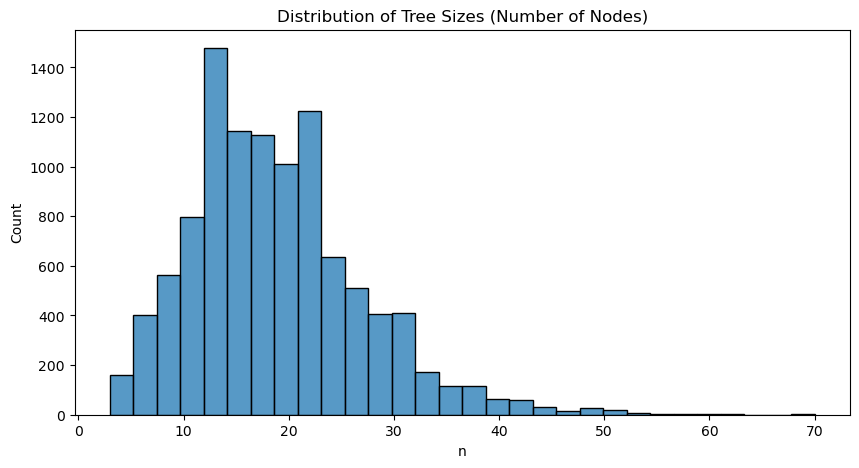

In [20]:
# Sentence length distribution
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='n', bins=30)
plt.title('Distribution of Tree Sizes (Number of Nodes)')
plt.show()

In [21]:
# Language distribution (check number of languages and number of sentences per language)
lang = df['language'].nunique()
print(f'There are {lang} languages. Each language has the following number of sentences:')
df['language'].value_counts()

There are 21 languages. Each language has the following number of sentences:


language
Japanese      500
German        500
Arabic        500
Portuguese    500
Chinese       500
Czech         500
Turkish       500
Thai          500
Polish        500
Korean        500
Icelandic     500
Finnish       500
Spanish       500
Swedish       500
Indonesian    500
Italian       500
French        500
Hindi         500
English       500
Galician      500
Russian       500
Name: count, dtype: int64

count    10500.000000
mean         9.844476
std          7.207740
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: root, dtype: float64


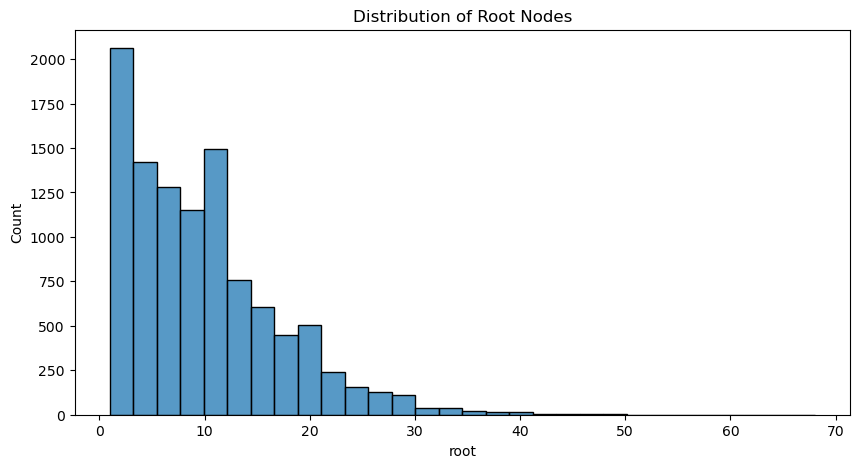

In [22]:
# Root node analysis
print(df['root'].describe())
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='root', bins=30)
plt.title('Distribution of Root Nodes')
plt.show()

In [23]:
def visualize_tree(edges, root, title=""):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    pos = nx.planar_layout(G) if nx.is_planar(G) else nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=800, node_color='lightblue')
    plt.title(f"Tree Visualization (Root: {root}) {title}")
    plt.show()

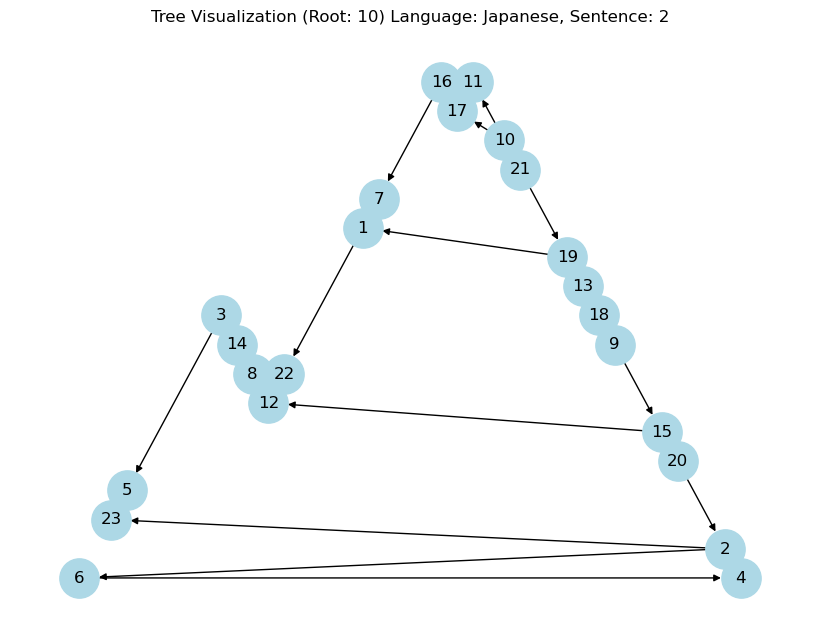

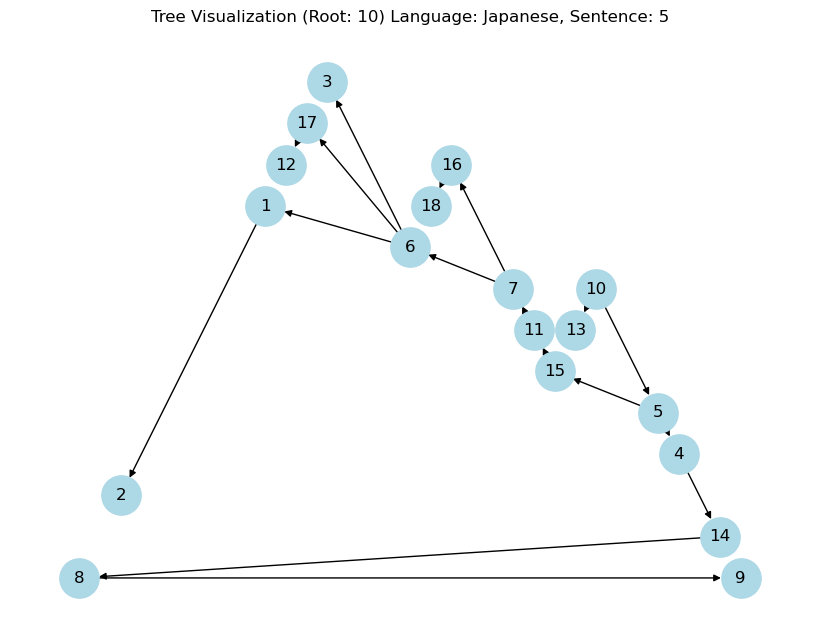

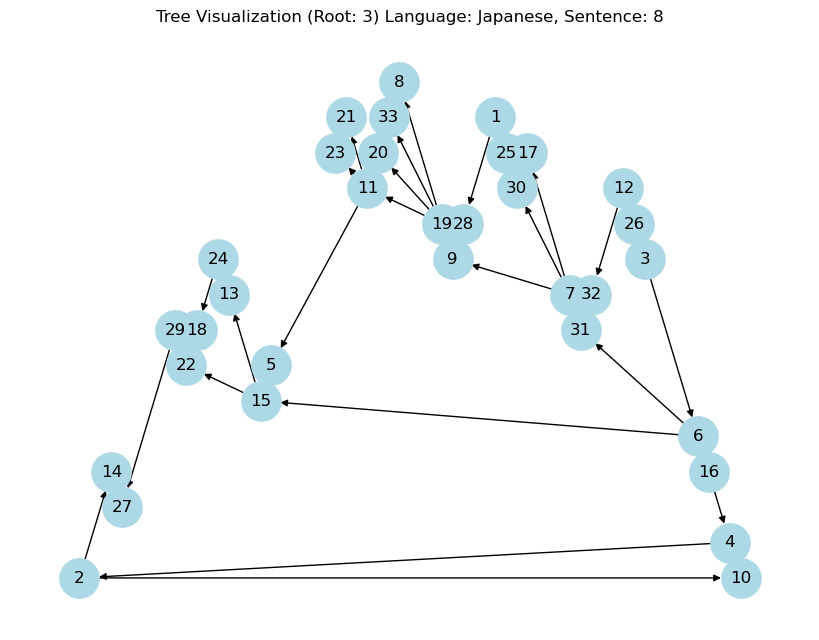

In [24]:
# Visualize first few trees
for i, row in df.head(3).iterrows():
    visualize_tree(row['edges'], row['root'], f"Language: {row['language']}, Sentence: {row['sentence']}")

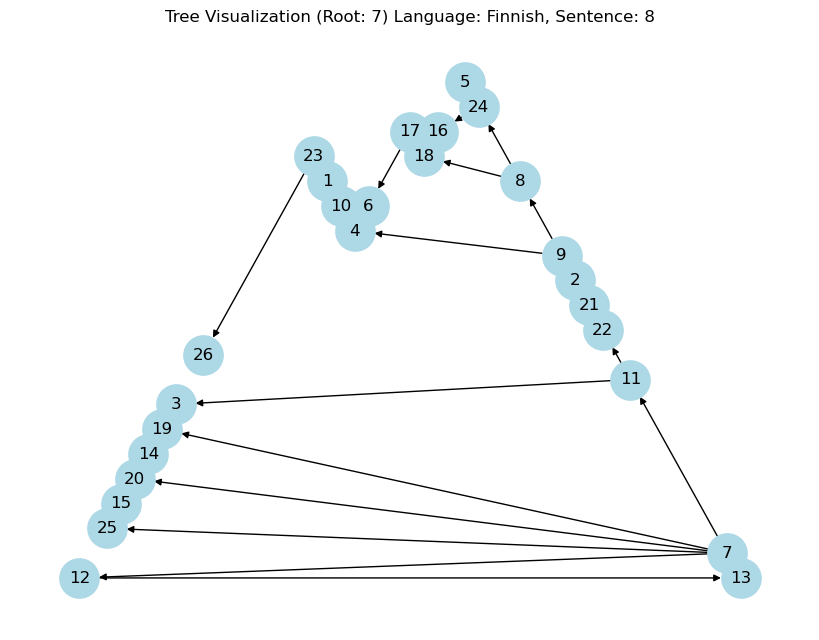

In [25]:
 visualize_tree(df.iloc[502]['edges'], df.iloc[502]['root'], f"Language: {df.iloc[502]['language']}, Sentence: {df.iloc[502]['sentence']}")

In [26]:
def centralities(edgelist):
    """
    - edgelist is a list of node pairs e.g. [(7,2),(1,7),(1,9),...]
    - returns a dictionary of vertex -> (centrality values)
    """
    T = nx.from_edgelist(edgelist)
    dc = nx.degree_centrality(T)
    cc = nx.harmonic_centrality(T)
    bc = nx.betweenness_centrality(T)
    pc = nx.pagerank(T)
    clc = nx.closeness_centrality(T)
    ec = nx.eigenvector_centrality_numpy(T)
    kz = nx.katz_centrality_numpy(T, alpha=0.005, beta=1.0)
    lc = nx.load_centrality(T)

    return {v: (dc[v], cc[v], bc[v], pc[v], clc[v], ec[v], kz[v], lc[v]) for v in T}

In [27]:
df['centralities'] = df['edges'].apply(centralities)

In [28]:
df.head()

,language,sentence,n,edgelist,root,edges,tree,centralities
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...","(6, 4, 2, 23, 20, 15, 3, 5, 14, 8, 12, 9, 18, ...","{6: (0.09090909090909091, 5.823845598845598, 0..."
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...","(8, 9, 14, 4, 5, 1, 2, 6, 17, 12, 3, 7, 11, 16...","{8: (0.11764705882352941, 4.907936507936508, 0..."
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...","(2, 10, 14, 4, 16, 6, 12, 32, 26, 3, 29, 27, 2...","{2: (0.09375, 8.167063492063495, 0.12298387096..."
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...","(30, 1, 14, 24, 21, 3, 7, 12, 27, 16, 8, 5, 26...","{30: (0.10344827586206896, 8.070310245310246, ..."
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...","(19, 13, 16, 2, 4, 10, 15, 5, 14, 12, 3, 1, 8,...","{19: (0.1111111111111111, 5.745238095238095, 0..."


In [29]:
# check with project guideline
df[(df['language'] == 'Arabic') & (df['sentence'] == 62)]

,language,sentence,n,edgelist,root,edges,tree,centralities
9529,Arabic,62,10,"[(5, 6), (5, 4), (5, 10), (10, 3), (10, 1), (1...",5,"[(5, 6), (5, 4), (5, 10), (10, 3), (10, 1), (1...","(5, 6, 4, 10, 3, 1, 2, 7, 8, 9)","{5: (0.3333333333333333, 5.283333333333333, 0...."


In [30]:
# copy data to new dataframe to make changes and not affect original copy
data = df.copy()

In [31]:
# confirm copy
data.head(1)

,language,sentence,n,edgelist,root,edges,tree,centralities
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...","(6, 4, 2, 23, 20, 15, 3, 5, 14, 8, 12, 9, 18, ...","{6: (0.09090909090909091, 5.823845598845598, 0..."


In [32]:
data = data.drop(['edgelist', 'edges', 'tree'], axis=1)
data.head(1)

,language,sentence,n,root,centralities
0,Japanese,2,23,10,"{6: (0.09090909090909091, 5.823845598845598, 0..."


for each vertex v in tree T:
* generate features from centralities
* set target = 1 if vertex is the root, otherwise it is 0
* add row (features, target) to binary classification training dataset

In [34]:
# Create list to store flattened records
records = []

# Iterate over each row in the original DataFrame to generate features from centralities
for _, row in data.iterrows():
    for vertex, centrality_metrics in row['centralities'].items():
        record = {
            'language': row['language'],
            'sentence': row['sentence'],
            'n': row['n'],
            'root': row['root'],
            'vertex': vertex,
            **{'centrality_' + str(i+1): centrality_metrics[i] for i in range(len(centrality_metrics))}
        }
        records.append(record)

# Convert the list of records back to dataframe
final_df = pd.DataFrame(records)

# rename centrality metric columns
final_df = final_df.rename(columns={
    'centrality_1': 'degree',
    'centrality_2': 'harmonic',
    'centrality_3': 'betweenness',
    'centrality_4': 'pagerank',
    'centrality_5': 'closeness',
    'centrality_6': 'eigenvector',
    'centrality_7': 'katz',
    'centrality_8': 'load'
})

# Sort by sentence and vertex 
final_df = final_df.sort_values(['language', 'sentence', 'vertex']).reset_index(drop=True)

final_df.head()

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load
0,Arabic,2,21,10,1,0.05,5.381349,0.000000,0.026870,0.202020,0.121919,0.217232,0.000000
1,Arabic,2,21,10,2,0.10,6.216270,0.394737,0.048072,0.192308,0.047211,0.218324,0.394737
2,Arabic,2,21,10,3,0.05,5.403211,0.000000,0.027086,0.178571,0.203677,0.217232,0.000000
3,Arabic,2,21,10,4,0.10,6.273016,0.442105,0.047721,0.210526,0.067535,0.218318,0.442105
4,Arabic,2,21,10,5,0.10,6.247655,0.100000,0.051047,0.198020,0.256177,0.218318,0.100000


In [35]:
# check with project guideline
final_df[(final_df['language'] == 'Arabic') & (final_df['sentence'] == 62)]

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load
588,Arabic,62,10,5,1,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000
589,Arabic,62,10,5,2,0.222222,5.000000,0.500000,0.104807,0.473684,0.368517,0.316552,0.500000
590,Arabic,62,10,5,3,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000
591,Arabic,62,10,5,4,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000
592,Arabic,62,10,5,5,0.333333,5.283333,0.416667,0.162218,0.428571,0.450105,0.318118,0.416667
593,Arabic,62,10,5,6,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000
594,Arabic,62,10,5,7,0.222222,4.500000,0.388889,0.108763,0.391304,0.218849,0.316536,0.388889
595,Arabic,62,10,5,8,0.222222,3.983333,0.222222,0.115810,0.310345,0.121933,0.316528,0.222222
596,Arabic,62,10,5,9,0.111111,3.016667,0.000000,0.064220,0.243243,0.054409,0.314953,0.000000
597,Arabic,62,10,5,10,0.444444,6.083333,0.750000,0.205094,0.529412,0.607014,0.319693,0.750000


In [36]:
# create is_root target value
final_df['is_root'] = (final_df['vertex'] == final_df['root']).astype(int)

final_df.head()

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
0,Arabic,2,21,10,1,0.05,5.381349,0.000000,0.026870,0.202020,0.121919,0.217232,0.000000,0
1,Arabic,2,21,10,2,0.10,6.216270,0.394737,0.048072,0.192308,0.047211,0.218324,0.394737,0
2,Arabic,2,21,10,3,0.05,5.403211,0.000000,0.027086,0.178571,0.203677,0.217232,0.000000,0
3,Arabic,2,21,10,4,0.10,6.273016,0.442105,0.047721,0.210526,0.067535,0.218318,0.442105,0
4,Arabic,2,21,10,5,0.10,6.247655,0.100000,0.051047,0.198020,0.256177,0.218318,0.100000,0


In [37]:
# check with project guideline
final_df[(final_df['language'] == 'Arabic') & (final_df['sentence'] == 62)]

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
588,Arabic,62,10,5,1,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000,0
589,Arabic,62,10,5,2,0.222222,5.000000,0.500000,0.104807,0.473684,0.368517,0.316552,0.500000,0
590,Arabic,62,10,5,3,0.111111,3.950000,0.000000,0.058583,0.360000,0.270862,0.314969,0.000000,0
591,Arabic,62,10,5,4,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000,0
592,Arabic,62,10,5,5,0.333333,5.283333,0.416667,0.162218,0.428571,0.450105,0.318118,0.416667,1
593,Arabic,62,10,5,6,0.111111,3.616667,0.000000,0.060961,0.310345,0.200846,0.314961,0.000000,0
594,Arabic,62,10,5,7,0.222222,4.500000,0.388889,0.108763,0.391304,0.218849,0.316536,0.388889,0
595,Arabic,62,10,5,8,0.222222,3.983333,0.222222,0.115810,0.310345,0.121933,0.316528,0.222222,0
596,Arabic,62,10,5,9,0.111111,3.016667,0.000000,0.064220,0.243243,0.054409,0.314953,0.000000,0
597,Arabic,62,10,5,10,0.444444,6.083333,0.750000,0.205094,0.529412,0.607014,0.319693,0.750000,0


In [38]:
# check with another sentence
final_df[(final_df['language'] == 'Chinese') & (final_df['sentence'] == 187)]

,language,sentence,n,root,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
11056,Chinese,187,3,1,1,1.0,2.0,1.0,0.486486,1.000000,0.707107,0.579260,1.0,1
11057,Chinese,187,3,1,2,0.5,1.5,0.0,0.256757,0.666667,0.500000,0.576393,0.0,0
11058,Chinese,187,3,1,3,0.5,1.5,0.0,0.256757,0.666667,0.500000,0.576393,0.0,0


In [39]:
# drop root column
final_df = final_df.drop('root', axis=1)

In [40]:
final_df.describe()

,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,6.590969,0.187322,0.053170,0.245772,0.181116,0.225162,0.187322,0.053170
std,291.353683,8.959233,8.269808,0.078688,2.057981,0.217725,0.036490,0.088976,0.142715,0.049724,0.217725,0.224373
min,2.000000,3.000000,1.000000,0.014493,1.500000,0.000000,0.007699,0.062864,0.000001,0.118939,0.000000,0.000000
25%,238.000000,16.000000,5.000000,0.052632,5.120635,0.000000,0.028860,0.183673,0.066948,0.191554,0.000000,0.000000
50%,491.000000,21.000000,10.000000,0.083333,6.333333,0.105105,0.043185,0.230216,0.148881,0.217238,0.105105,0.000000
75%,736.000000,27.000000,16.000000,0.133333,7.782527,0.341667,0.066175,0.290000,0.258312,0.250142,0.341667,0.000000
max,995.000000,70.000000,70.000000,1.000000,20.078175,1.000000,0.486486,1.000000,0.707107,0.579260,1.000000,1.000000


In [41]:
final_df

,language,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
0,Arabic,2,21,1,0.050000,5.381349,0.000000,0.026870,0.202020,0.121919,0.217232,0.000000,0
1,Arabic,2,21,2,0.100000,6.216270,0.394737,0.048072,0.192308,0.047211,0.218324,0.394737,0
2,Arabic,2,21,3,0.050000,5.403211,0.000000,0.027086,0.178571,0.203677,0.217232,0.000000,0
3,Arabic,2,21,4,0.100000,6.273016,0.442105,0.047721,0.210526,0.067535,0.218318,0.442105,0
4,Arabic,2,21,5,0.100000,6.247655,0.100000,0.051047,0.198020,0.256177,0.218318,0.100000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197474,Turkish,995,16,12,0.133333,5.716667,0.133333,0.069567,0.283019,0.118763,0.250144,0.133333,0
197475,Turkish,995,16,13,0.266667,8.416667,0.666667,0.120857,0.454545,0.416249,0.252652,0.666667,1
197476,Turkish,995,16,14,0.133333,6.183333,0.133333,0.068705,0.306122,0.239174,0.250156,0.133333,0
197477,Turkish,995,16,15,0.066667,5.533333,0.000000,0.035338,0.319149,0.172776,0.248900,0.000000,0


In [42]:
final_df.to_csv('binary_dataset.csv', index=False)

In [43]:
train_df = pd.read_csv('binary_dataset.csv')

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197479 entries, 0 to 197478
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   language     197479 non-null  object 
 1   sentence     197479 non-null  int64  
 2   n            197479 non-null  int64  
 3   vertex       197479 non-null  int64  
 4   degree       197479 non-null  float64
 5   harmonic     197479 non-null  float64
 6   betweenness  197479 non-null  float64
 7   pagerank     197479 non-null  float64
 8   closeness    197479 non-null  float64
 9   eigenvector  197479 non-null  float64
 10  katz         197479 non-null  float64
 11  load         197479 non-null  float64
 12  is_root      197479 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 19.6+ MB


- change language to categorical variable


In [46]:
train_df['language'] = train_df['language'].astype('category')

In [47]:
# get number of rows and columns
train_df.shape

(197479, 13)

In [48]:
# confirm there are no missing values
train_df.isnull().sum()

language       0
sentence       0
n              0
vertex         0
degree         0
harmonic       0
betweenness    0
pagerank       0
closeness      0
eigenvector    0
katz           0
load           0
is_root        0
dtype: int64

In [49]:
# Check for duplicates
train_df.duplicated().sum()

0

In [50]:
# check other variables in the data
df.columns

Index(['language', 'sentence', 'n', 'edgelist', 'root', 'edges', 'tree',
       'centralities'],
      dtype='object')

In [51]:
train_df.describe()

,sentence,n,vertex,degree,harmonic,betweenness,pagerank,closeness,eigenvector,katz,load,is_root
count,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000,197479.000000
mean,499.636584,22.374151,11.687076,0.106340,6.590969,0.187322,0.053170,0.245772,0.181116,0.225162,0.187322,0.053170
std,291.353683,8.959233,8.269808,0.078688,2.057981,0.217725,0.036490,0.088976,0.142715,0.049724,0.217725,0.224373
min,2.000000,3.000000,1.000000,0.014493,1.500000,0.000000,0.007699,0.062864,0.000001,0.118939,0.000000,0.000000
25%,238.000000,16.000000,5.000000,0.052632,5.120635,0.000000,0.028860,0.183673,0.066948,0.191554,0.000000,0.000000
50%,491.000000,21.000000,10.000000,0.083333,6.333333,0.105105,0.043185,0.230216,0.148881,0.217238,0.105105,0.000000
75%,736.000000,27.000000,16.000000,0.133333,7.782527,0.341667,0.066175,0.290000,0.258312,0.250142,0.341667,0.000000
max,995.000000,70.000000,70.000000,1.000000,20.078175,1.000000,0.486486,1.000000,0.707107,0.579260,1.000000,1.000000


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197479 entries, 0 to 197478
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   language     197479 non-null  category
 1   sentence     197479 non-null  int64   
 2   n            197479 non-null  int64   
 3   vertex       197479 non-null  int64   
 4   degree       197479 non-null  float64 
 5   harmonic     197479 non-null  float64 
 6   betweenness  197479 non-null  float64 
 7   pagerank     197479 non-null  float64 
 8   closeness    197479 non-null  float64 
 9   eigenvector  197479 non-null  float64 
 10  katz         197479 non-null  float64 
 11  load         197479 non-null  float64 
 12  is_root      197479 non-null  int64   
dtypes: category(1), float64(8), int64(4)
memory usage: 18.3 MB


### Resampling

To estimate the generalization error, we split the data into train and test set. We will then use a 10-fold cross validation over the train set so we train over a good sample of the data

In [54]:
# separate features and target value
X = train_df.drop('is_root', axis=1)
y = train_df['is_root']


In [56]:
# to avoid data leakage use group split
from sklearn.model_selection import GroupShuffleSplit

# Grouping by sentence ID
groups = train_df['sentence'] 

# Perform group split (80% train, 20% test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verify no sentence appears in both splits
train_sentences = set(groups.iloc[train_idx])
test_sentences = set(groups.iloc[test_idx])
assert train_sentences.isdisjoint(test_sentences), "Data leakage detected!"

### Preprocessing

It will be better to normalize the data since it has different different ranges. we cave to do a sentence level normalization because different sentences have different number of nodes

In [58]:
# store sentence ids for per sentence scaling
train_groups, test_groups = groups.iloc[train_idx], groups.iloc[test_idx]

## Note

Group by language then sentence coz per sentence will scakle all the sentences from all the languages as one. however for example, Arabic and Turkish trees for the same sentence may have different structures, so we Normalize per-language AND per-sentence by grouping by both language and sentence. treating them as a single group would mix languages during normalization.

question: should we drop vertex. how will the model see the vertext column when fitting the data. for example, 1 in sencence 2 can be 'food', 
1 sentence 4 can be 'exam', so will the model treat the numerical values as the same value or not

In [60]:
from sklearn.preprocessing import MinMaxScaler

def preprocessing(X, sentence_ids, languages):
    X_normalized = X.copy()

    # Get unique languages
    unique_languages = languages.unique()
    
    # Process each language group separately
    for language in unique_languages:
        # Get rows for this language
        language_mask = (languages == language)
        X_language = X.loc[language_mask]
        sentence_ids_language = sentence_ids.loc[language_mask]
        
        # Get unique sentence IDs within this language
        unique_sentences = sentence_ids_language.unique()

    # Process each sentence group within this language
        for sentence_id in unique_sentences:
            # Get rows for this sentence within this language
            sentence_mask = (sentence_ids_language == sentence_id)
            combined_mask = language_mask & (sentence_ids == sentence_id)
            
            # Process each centrality column separately
            for col in X.drop(['language', 'sentence', 'vertex','n'], axis=1).columns:
                scaler = MinMaxScaler()
                values = X_language.loc[sentence_mask, col].values.reshape(-1, 1)
                normalized_values = scaler.fit_transform(values)
                X_normalized.loc[combined_mask, col] = normalized_values.flatten()
            
    return X_normalized

train_sentences_ids = groups.iloc[train_idx]
test_sentences_ids = groups.iloc[test_idx]

train_languages = X_train.language
test_languages = X_test.language

# Normalize features within each split
X_train_normalized = preprocessing(X_train, train_sentences_ids, train_languages)
X_test_normalized = preprocessing(X_test, test_sentences_ids, test_languages)


we fit and transform the test set independently because the sentences are different in the two sets, so we can't use the scalers used for train to transform the test set, as we performed a within sentence normalization

We also only performed normalization on the centrality metrics and on the number of nodes n

In [62]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_normalized['n'] = std_scaler.fit_transform(X_train_normalized[['n']])
X_test_normalized['n'] = std_scaler.transform(X_test_normalized[['n']])

We do a global normalization on the number of nodes (n), since n has a wide range- min is 3 and max is 70, so it's safer to normalize 
we use a standard scaler because MinMaxScaler squeezes values into [0, 1] based on global min/max which would cause a tiny change in n (e.g., 8 vs. 10) to get compressed into a small range, while outliers (e.g., n=50) dominate the scale.

Advantages of StandardScaler (Z-score) Preserves relative differences between values better than MinMaxScaler. and is Robust to outliers: A sentence with n=50 won’t distort the entire scale.


In [64]:
# drop columns not useful, vertex is an identifier, so should be dropped
X_train_normalized = X_train_normalized.drop(['language', 'sentence', 'vertex'], axis=1)
X_test_normalized = X_test_normalized.drop(['language', 'sentence', 'vertex'], axis=1)

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score

lg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],             # Regularization strength
    'penalty': ['l2'],                  # l1 requires solver='liblinear' or 'saga'
    'solver': ['lbfgs', 'liblinear'],                # 'lbfgs' supports l2 and multiclass
}

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',   
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_normalized, y_train, groups=X_train['sentence'])


# Train
logreg = grid_search.best_estimator_

# Predict
y_pred = logreg.predict(X_test_normalized)
y_probs = logreg.predict_proba(X_test_normalized)[:, 1]  # Probabilities for root class

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [66]:
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))


Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     37903
           1       0.15      0.76      0.24      2100

    accuracy                           0.75     40003
   macro avg       0.56      0.76      0.55     40003
weighted avg       0.94      0.75      0.82     40003

Test F1 Score: 0.24475040381509114


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline

# Initialize Random Forest with balanced class weights
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    n_jobs=-1  # Parallel processing
)

# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],       # Number of trees
    'max_depth': [None, 10, 20],      # Tree depth
    'min_samples_split': [2, 5],      # Minimum samples to split
    'max_features': ['sqrt', 'log2']  # Features per split
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=10),  # 10-fold grouped CV
    scoring='f1',                # Focus on F1 for root class
    n_jobs=-1,                   # Parallelize
    verbose=1
)

# Fit (ensure X_train doesn't contain 'sentence' column)
grid_search.fit(
    X_train_normalized,  # Exclude group identifier
    y_train,
    groups=X_train['sentence']  # Grouping key
)

# Best model
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test_normalized)
y_probs = best_rf.predict_proba(X_test_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))

# Feature Importance
importances = best_rf.feature_importances_
print("Feature Importances:", dict(zip(X_train_normalized, importances)))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     37903
           1       0.22      0.45      0.30      2100

    accuracy                           0.89     40003
   macro avg       0.60      0.68      0.62     40003
weighted avg       0.93      0.89      0.91     40003

Test F1 Score: 0.2998258667088808
Feature Importances: {'n': 0.07181692378876327, 'degree': 0.030612185220471808, 'harmonic': 0.1347884774110048, 'betweenness': 0.1714963447559166, 'pagerank': 0.10097001751015862, 'closeness': 0.08104489266025044, 'eigenvector': 0.10110257031189741, 'katz': 0.16196278609400053, 'load': 0.1462058022475366}


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 15, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 63}

Classification Report:
              precision    recall  f1-score   support

    Non-Root       0.98      0.80      0.88     37903
        Root       0.16      0.69      0.26      2100

    accuracy                           0.79     40003
   macro avg       0.57      0.74      0.57     40003
weighted avg       0.94      0.79      0.84     40003

Test F1 Score (Root): 0.2562

Feature Importances (Gain):
eigenvector: 2008.0000
pagerank: 1896.0000
n: 1891.0000
closeness: 1810.0000
harmonic: 1596.0000
betweenness: 1580.0000
katz: 1378.0000
degree: 241.0000
load: 0.0000


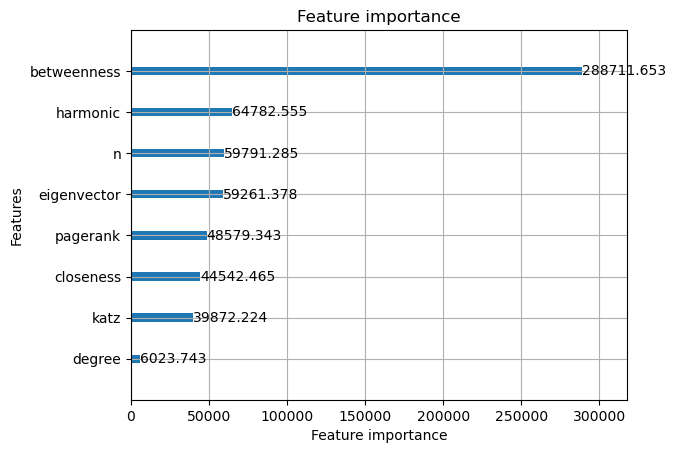

In [82]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Initialize LightGBM with imbalance handling
lgbm_model = LGBMClassifier(
    boosting_type='goss',  # Better for imbalanced data
    objective='binary',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    reg_alpha=0.1,
    reg_lambda=0.1,
    learning_rate=0.1,
    verbose=-1  # Silence output
)

# Parameter grid optimized for root prediction
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'num_leaves': [31, 63],  # Should be <= 2^max_depth
    'min_child_samples': [5, 10, 20],  # Helps with imbalance
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit with sentence groups
grid_search.fit(
    X_train_normalized,
    y_train,
    groups=X_train['sentence'],  # Critical for your data structure
    eval_metric='f1'
)

# Best model
best_lgbm = grid_search.best_estimator_

# Predictions
y_pred = best_lgbm.predict(X_test_normalized)
y_probs = best_lgbm.predict_proba(X_test_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Root', 'Root']))
print(f"Test F1 Score (Root): {f1_score(y_test, y_pred, pos_label=1):.4f}")

# Feature Importance (gain-based)
importances = best_lgbm.feature_importances_
importance_dict = dict(zip(X_train_normalized.columns, importances))
print("\nFeature Importances (Gain):")
for feat, imp in sorted(importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feat}: {imp:.4f}")

# Optional: Plot importance
import matplotlib.pyplot as plt
from lightgbm import plot_importance
plot_importance(best_lgbm, importance_type='gain', max_num_features=15)
plt.show()

In [ ]:
sentences_ids = X.sentence

languages = X.language

# Normalize features within each split
X_normalized = preprocessing(X, sentences_ids, languages)
X_normalized = X_normalized.drop(['language', 'sentence', 'vertex'], axis=1)
X_normalized['n'] = std_scaler.fit_transform(X_normalized[['n']])


In [ ]:
# Fit (ensure X_train doesn't contain 'sentence' column)
best_rf.fit(
    X_normalized,  # Exclude group identifier
    y  # Grouping key
)

In [ ]:
# read training data
test_df = pd.read_csv('test.csv')
# convert string to list of edges
test_df['edges'] = test_df['edgelist'].apply(ast.literal_eval)
# create tree
test_df['tree'] = test_df['edges'].apply(nx.from_edgelist)
test_df['centralities'] = test_df['edges'].apply(centralities)

test_df = test_df.drop(['edgelist', 'edges', 'tree'], axis=1)

# Create list to store flattened records
test_records = []

# Iterate over each row in the original DataFrame to generate features from centralities
for _, row in test_df.iterrows():
    for vertex, centrality_metrics in row['centralities'].items():
        test_record = {
            'language': row['language'],
            'sentence': row['sentence'],
            'n': row['n'],
            'vertex': vertex,
            **{'centrality_' + str(i+1): centrality_metrics[i] for i in range(len(centrality_metrics))}
        }
        test_records.append(test_record)

# Convert the list of records back to dataframe
test_df = pd.DataFrame(test_records)

# rename centrality metric columns
test_df = test_df.rename(columns={
    'centrality_1': 'degree',
    'centrality_2': 'harmonic',
    'centrality_3': 'betweenness',
    'centrality_4': 'pagerank',
    'centrality_5': 'closeness',
    'centrality_6': 'eigenvector',
    'centrality_7': 'katz',
    'centrality_8': 'load'
})

# Sort by sentence and vertex 
test_df = test_df.sort_values(['language', 'sentence', 'vertex']).reset_index(drop=True)

test_df.head()

In [ ]:
test_df_sentences_ids = test_df.sentence

test_df_languages = test_df.language

# Normalize features within each split
test_df = preprocessing(test_df, test_df_sentences_ids, test_df_languages)
test_df['n'] = std_scaler.fit_transform(test_df[['n']])
test = test_df.drop(['language', 'sentence', 'vertex'], axis=1)
test.head()

In [ ]:
test_df['n']

In [ ]:
# Predictions
test_pred = best_rf.predict(test)
test_probs = best_rf.predict_proba(test)[:, 1]



In [ ]:
test_df['probability'] = test_probs

In [ ]:
df_max = test_df.loc[test_df.groupby(['language', 'sentence'])['probability'].idxmax()]

submission_df = df_max[['language','sentence', 'vertex']].rename(columns={'vertex': 'root'}).reset_index(drop=True)

In [ ]:
submission_df

In [ ]:
sub = df_sen.merge(submission_df, on=['language', 'sentence'], how='left')

In [ ]:
sub = sub[['id', 'root']]

In [ ]:
sub.to_csv('rf_submission_more_feat.csv', index=False)
print("Submission file created: rf_submission_more_feat.csv")


accuracy shouldnt be used as a metric when there is class imbalance

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Initialize XGBoost with scale_pos_weight for imbalance
# scale_pos_weight = (negative_samples / positive_samples)
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
xgb_model = XGBClassifier(
    scale_pos_weight=neg_pos_ratio,  # Critical for imbalance
    eval_metric='logloss',          
    random_state=42,
    n_jobs=-1,
    tree_method='hist'              # Faster training
)

# Parameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]  # Minimum loss reduction for splits
}

# Group-aware GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=GroupKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit (exclude sentence column from features)
grid_search.fit(
    X_train_normalized,
    y_train,
    groups=X_train['sentence'],
    verbose=0
)

# Best model
best_xgb = grid_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_test_normalized)
y_probs = best_xgb.predict_proba(X_test_normalized)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))

# Feature Importance
from xgboost import plot_importance
plot_importance(best_xgb, max_num_features=10)